In [ ]:
#Download Data
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
#Check the data
import os
def print_category(root_dir, set_name):
    print(f"\n{set_name} set:")
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            images = [img for img in os.listdir(category_path)]
            print(f"Category '{category}' have {len(images)} images.")
training_dir = os.path.join(path, "Training")
testing_dir = os.path.join(path, "Testing")
print_category(training_dir, "Training")
print_category(testing_dir, "Testing")


Training set:
Category 'pituitary' have 1457 images.
Category 'notumor' have 1595 images.
Category 'glioma' have 1321 images.
Category 'meningioma' have 1339 images.

Testing set:
Category 'pituitary' have 300 images.
Category 'notumor' have 405 images.
Category 'glioma' have 300 images.
Category 'meningioma' have 306 images.


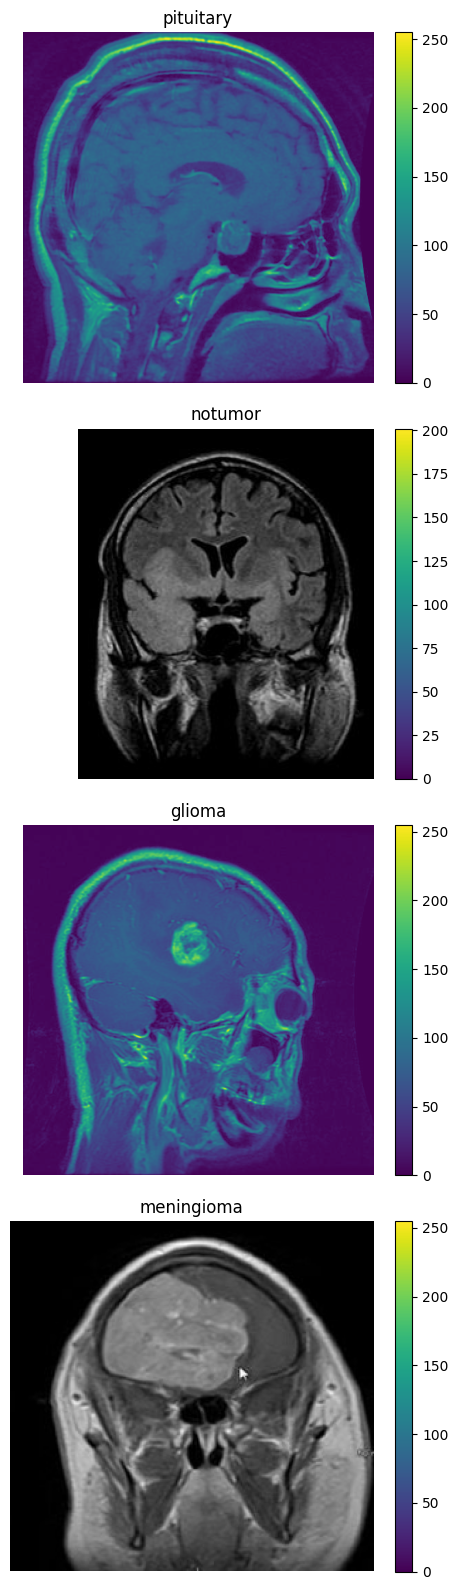

In [ ]:
#Plot the example images, to determine the data prepocessing techniques
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
training_dir = os.path.join(path, "Testing")
categories = [cat for cat in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, cat))]
num_categories = len(categories)
fig, axes = plt.subplots(num_categories, 1, figsize=(6, 4 * num_categories))
if num_categories == 1:
    axes = [axes]
for idx, category in enumerate(categories):
    category_path = os.path.join(training_dir, category)
    image_files = [img for img in os.listdir(category_path)
                   if img.lower().endswith((".jpg", ".jpeg", ".png"))]
    if image_files:
        sample_image_path = os.path.join(category_path, image_files[0])
        img = Image.open(sample_image_path)
        img_array = np.array(img)
        im_plot = axes[idx].imshow(img_array, cmap='viridis')
        axes[idx].set_title(category)
        axes[idx].axis("off")
        fig.colorbar(im_plot, ax=axes[idx], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

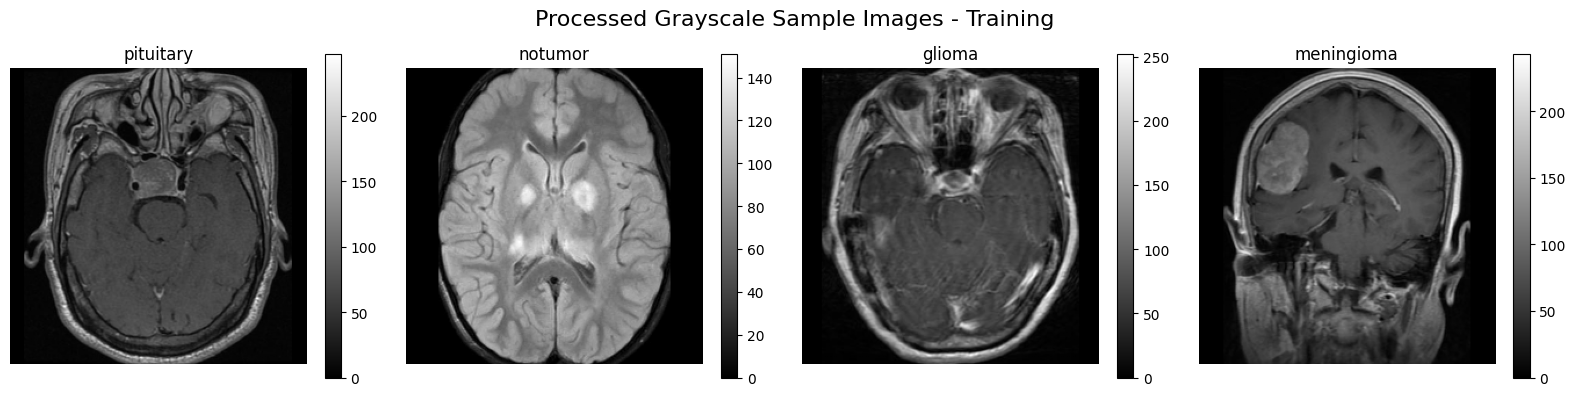

'\nnum_categories_test = len(sample_images_test)\nfig_test, axes_test = plt.subplots(1, num_categories_test, figsize=(4 * num_categories_test, 4))\nif num_categories_test == 1:\n    axes_test = [axes_test]\nfor ax, (category, img) in zip(axes_test, sample_images_test.items()):\n    im = ax.imshow(img, cmap="gray")\n    ax.set_title(category)\n    ax.axis("off")\n    fig_test.colorbar(im, ax=ax, orientation="vertical")\nplt.suptitle("Processed Grayscale Sample Images - Testing", fontsize=16)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
#Data Prepocessing - Refer to https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py
import cv2
import imutils

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

def resize(image, target_size=(256, 256), padding_color=(0, 0, 0)):
    h, w = image.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    pad_w = target_w - new_w
    pad_h = target_h - new_h
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    padd_image = cv2.copyMakeBorder(resized, top, bottom, left, right,cv2.BORDER_CONSTANT, value=padding_color)
    return padd_image

def process_dataset(dataset_dir, img_size=256):
    categories = [cat for cat in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cat))]
    sample_image = {}
    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        image_files = [img for img in os.listdir(category_path) if img.lower().endswith((".jpg", ".jpeg", ".png"))]
        if image_files:
            sample_image_path = os.path.join(category_path, image_files[0])
            image = cv2.imread(sample_image_path)
            cropped = crop_img(image)
            resize_image = resize(cropped, target_size=(img_size, img_size))
            gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY)
            sample_image[category] = gray_image
    return sample_image

training_dir = os.path.join(path, "Training")
#testing_dir = os.path.join(path, "Testing")
sample_images_train = process_dataset(training_dir, img_size=256)
#sample_images_test = process_dataset(testing_dir, img_size=256)
num_categories_train = len(sample_images_train)
fig_train, axes_train = plt.subplots(1, num_categories_train, figsize=(4 * num_categories_train, 4))
if num_categories_train == 1:
    axes_train = [axes_train]
for ax, (category, img) in zip(axes_train, sample_images_train.items()):
    im = ax.imshow(img, cmap="gray")
    ax.set_title(category)
    ax.axis("off")
    fig_train.colorbar(im, ax=ax, orientation="vertical")
plt.suptitle("Processed Grayscale Sample Images - Training", fontsize=16)
plt.tight_layout()
plt.show()
'''
num_categories_test = len(sample_images_test)
fig_test, axes_test = plt.subplots(1, num_categories_test, figsize=(4 * num_categories_test, 4))
if num_categories_test == 1:
    axes_test = [axes_test]
for ax, (category, img) in zip(axes_test, sample_images_test.items()):
    im = ax.imshow(img, cmap="gray")
    ax.set_title(category)
    ax.axis("off")
    fig_test.colorbar(im, ax=ax, orientation="vertical")
plt.suptitle("Processed Grayscale Sample Images - Testing", fontsize=16)
plt.tight_layout()
plt.show()
'''

In [ ]:
#Load Data and Normalization
def load_dataset(dataset_dir, img_size=256):
    images = []
    labels = []
    categories = sorted([cat for cat in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cat))])
    for label, category in enumerate(categories):
        cat_path = os.path.join(dataset_dir, category)
        image_files = [f for f in os.listdir(cat_path) if f.lower().endswith((".jpg",".jpeg",".png"))]
        for f in image_files:
            img_path = os.path.join(cat_path, f)
            image = cv2.imread(img_path)
            cropped = crop_img(image)
            resized = resize(cropped, target_size=(img_size, img_size))
            gray_image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
            images.append(gray_image)
            labels.append(label)
    images = np.array(images, dtype=np.float32)
    images = np.expand_dims(images, axis=-1)
    #Normalization
    for i in range(images.shape[0]):
        max_val = images[i].max()
        if max_val > 0:
            images[i] /= max_val
        else:
            images[i] = 0
    labels = np.array(labels)
    return images, labels, categories
training_dir = os.path.join(path, "Training")
testing_dir = os.path.join(path, "Testing")
X_train, y_train, train_categories = load_dataset(training_dir, img_size=256)
X_test, y_test, test_categories = load_dataset(testing_dir, img_size=256)
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)
print("Categories:", train_categories)

Training images shape: (5712, 256, 256, 1)
Training labels shape: (5712,)
Testing images shape: (1311, 256, 256, 1)
Testing labels shape: (1311,)
Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [1]:
#Model Network - Refer to the TransUnet shared in Emma's Github.
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        skip = x
        pool = self.pool(x)
        return skip, pool

class TransUNetClassifier(nn.Module):
    def __init__(self, input_shape, num_classes, patch_size, embed_dim, num_heads, ff_dim, num_transformer_blocks):
        """
        input_shape: (C, H, W)
        """
        super(TransUNetClassifier, self).__init__()
        in_channels = input_shape[0]

        # Encoder Path
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)

        # Patch Embedding: use convolution to create patches and map to embed_dim
        self.patch_size = patch_size
        self.patch_conv = nn.Conv2d(128, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Transformer Encoder: using PyTorch's built-in TransformerEncoderLayer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_blocks)

        # Global Average Pooling to aggregate the sequence
        # Fully connected classification head
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Encoder Path
        s1, pool1 = self.encoder1(x)     # pool1 shape: (B, 64, H/2, W/2)
        s2, pool2 = self.encoder2(pool1)   # pool2 shape: (B, 128, H/4, W/4)
        # Get the shape of pool2
        B, C, H, W = pool2.shape

        # Padding: ensure H and W are divisible by patch_size
        pad_h = (self.patch_size - H % self.patch_size) % self.patch_size
        pad_w = (self.patch_size - W % self.patch_size) % self.patch_size
        if pad_h > 0 or pad_w > 0:
            # F.pad(pad=(left, right, top, bottom))
            pool2 = F.pad(pool2, (0, pad_w, 0, pad_h))

        # Patch Embedding: use convolution to split the feature map into patches and map them to embed_dim
        patches = self.patch_conv(pool2)  # shape: (B, embed_dim, H', W')
        B, E, H_p, W_p = patches.shape
        num_patches = H_p * W_p
        # Reshape into a sequence: (num_patches, B, embed_dim)
        patches = patches.view(B, E, num_patches).permute(2, 0, 1)

        # Transformer Encoder
        transformer_out = self.transformer_encoder(patches)  # shape: (num_patches, B, embed_dim)
        # Global Average Pooling over the patch dimension (i.e., sequence dimension)
        pooled = transformer_out.mean(dim=0)  # shape: (B, embed_dim)

        # Fully Connected Head for classification
        x = F.relu(self.fc1(pooled))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


In [ ]:
#Model Traning and Testing
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2)
y_test_tensor = torch.from_numpy(y_test).long()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransUNetClassifier(input_shape=(1, 256, 256),num_classes=4,patch_size=4,embed_dim=128,num_heads=4,ff_dim=256,num_transformer_blocks=2)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)

num_epochs = 100
best_acc = 0
for epoch in range(num_epochs):
    model.train()
    loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        for i in range(labels.size(0)):
          if predicted[i].item() == labels[i].item():
              correct += 1
    epoch_loss = loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Training Accuracy = {epoch_acc:.2f}%")
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            for i in range(labels.size(0)):
              if predicted[i].item() == labels[i].item():
                  test_correct += 1
    test_acc = test_correct / test_total * 100
    print(f"Test Accuracy: {test_acc:.2f}%")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "Tumor_classify_TransUnet.pt")
        print(f"New best test accuracy: {best_acc:.2f}%")
print(f"Best Test Accuracy: {best_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100: Loss = 0.0161, Training Accuracy = 41.04%
Test Accuracy: 50.65%
New best test accuracy: 50.65%
Epoch 2/100: Loss = 0.0165, Training Accuracy = 52.17%
Test Accuracy: 54.16%
New best test accuracy: 54.16%
Epoch 3/100: Loss = 0.0134, Training Accuracy = 55.93%
Test Accuracy: 52.56%
Epoch 4/100: Loss = 0.0129, Training Accuracy = 56.36%
Test Accuracy: 54.69%
New best test accuracy: 54.69%
Epoch 5/100: Loss = 0.0121, Training Accuracy = 58.26%
Test Accuracy: 59.57%
New best test accuracy: 59.57%
Epoch 6/100: Loss = 0.0121, Training Accuracy = 60.73%
Test Accuracy: 59.88%
New best test accuracy: 59.88%
Epoch 7/100: Loss = 0.0147, Training Accuracy = 64.27%
Test Accuracy: 58.58%
Epoch 8/100: Loss = 0.0106, Training Accuracy = 63.15%
Test Accuracy: 62.47%
New best test accuracy: 62.47%
Epoch 9/100: Loss = 0.0093, Training Accuracy = 66.44%
Test Accuracy: 65.06%
New best test accuracy: 65.06%
Epoch 10/100: Loss = 0.0081, Training Accuracy = 68.17%
Test Accuracy: 66.06%
New best tes

In [ ]:
#Recheck the Best Testing Accuracy, 94.20%
from google.colab import files
uploaded = files.upload()
print(uploaded.keys())
model = TransUNetClassifier(input_shape=(1,256,256), num_classes=4, patch_size=4, embed_dim=128, num_heads=4, ff_dim=256, num_transformer_blocks=2)
model.load_state_dict(torch.load("Tumor_classify_TransUnet_v2.pt"))
model.to(device)
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

Saving Tumor_classify_TransUnet_v2.pt to Tumor_classify_TransUnet_v2 (2).pt
dict_keys(['Tumor_classify_TransUnet_v2 (2).pt'])


<ipython-input-107-7ef88a437327>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Tumor_classify_TransUnet_v2.pt"))


Test Accuracy: 94.20%


94


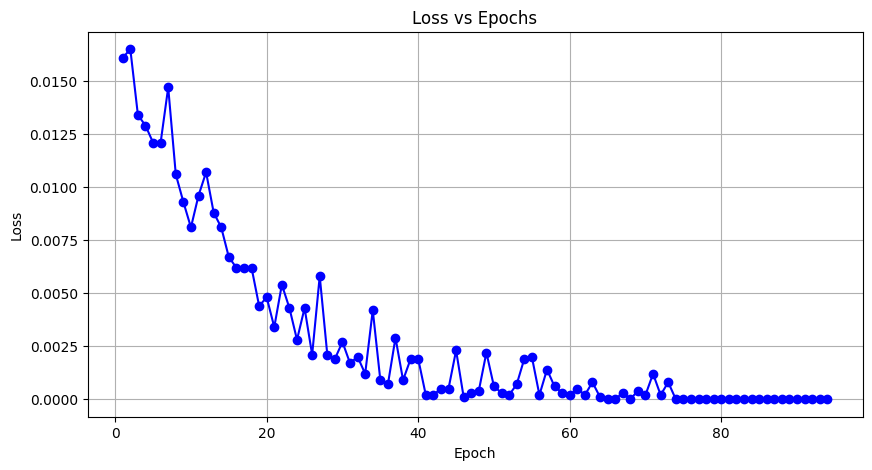

In [ ]:
#Overview of Loss function
import matplotlib.pyplot as plt

loss_list = [
    0.0161, 0.0165, 0.0134, 0.0129, 0.0121, 0.0121, 0.0147, 0.0106, 0.0093, 0.0081,
    0.0096, 0.0107, 0.0088, 0.0081, 0.0067, 0.0062, 0.0062, 0.0062, 0.0044, 0.0048,
    0.0034, 0.0054, 0.0043, 0.0028, 0.0043, 0.0021, 0.0058, 0.0021, 0.0019, 0.0027,
    0.0017, 0.0020, 0.0012, 0.0042, 0.0009, 0.0007, 0.0029, 0.0009, 0.0019, 0.0019,
    0.0002, 0.0002, 0.0005, 0.0005, 0.0023, 0.0001, 0.0003, 0.0004, 0.0022, 0.0006,
    0.0003, 0.0002, 0.0007, 0.0019, 0.0020, 0.0002, 0.0014, 0.0006, 0.0003, 0.0002,
    0.0005, 0.0002, 0.0008, 0.0001, 0.0000, 0.0000, 0.0003, 0.0000, 0.0004, 0.0002,
    0.0012, 0.0002, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000
]
print(len(loss_list))
epochs = range(1, 95)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_list, marker='o', linestyle='-', color='blue')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [3]:
# Evaluate the model in real scenario
from google.colab import files
import io
from PIL import Image
import cv2
import numpy as np
import torch
import torch.nn.functional as F

uploaded = files.upload()
print("Uploaded model file(s):", list(uploaded.keys()))
model = TransUNetClassifier(input_shape=(1, 256, 256),num_classes=4,patch_size=4,embed_dim=128,num_heads=4,ff_dim=256,num_transformer_blocks=2)

model.load_state_dict(torch.load("Tumor_classify_TransUnet_v2.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

uploaded_img = files.upload()
filename = list(uploaded_img.keys())[0]
print("Uploaded image:", filename)
pil_img = Image.open(io.BytesIO(uploaded_img[filename]))
img = np.array(pil_img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(gray_img, (256, 256))
max_val = img_resized.max()
if max_val > 0:
    img_norm = img_resized / max_val
else:
    img_norm = img_resized
img_norm = np.expand_dims(img_norm, axis=-1)
img_tensor = torch.from_numpy(img_norm.astype(np.float32)).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
train_categories = ["glioma", "meningioma", "notumor", "pituitary"]
predicted_category = train_categories[predicted.item()]
print("Predicted category:", predicted_category)

Saving Tumor_classify_TransUnet_v2.pt to Tumor_classify_TransUnet_v2 (1).pt
Uploaded model file(s): ['Tumor_classify_TransUnet_v2 (1).pt']


<ipython-input-3-ee46c439866e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Tumor_classify_TransUnet_v2.pt"))


Saving Te-glTr_0004.jpg to Te-glTr_0004.jpg
Uploaded image: Te-glTr_0004.jpg
Predicted category: glioma
